# Estimation of time-varying volatility using Levy distribution (large $n$)

In [1]:
#Import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import levy
from scipy.special import erfc, erfinv, gamma, gammainc
import math
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
import time

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line

# scipy for qq plots
import statsmodels.api as sm
import scipy.stats as stats

/Users/kotakikuchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/kotakikuchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# some pandas option setting
pd.options.display.max_rows = 150

In [3]:
# python plot options
plt.rcParams['figure.dpi'] = 500

In [4]:
sys.path.append('../../tools')
import tools

In [5]:
importlib.reload(tools)

<module 'tools' from '../../tools/tools.py'>

## Estimating Time-varying Volatility

#### general set-up

In [30]:
# Paramater for t (here store as t)
ts  = np.array([0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])


S = np.array([1000])
Ns = np.array([1000])

# Color for and types for graph
colors = ['r','g','b','black']
types = ['solid','dashed','dashdot','dotted']

In [31]:
a_ns = [
    8*(Ns)**(2.0)/(max(ts) - min(ts)),
    8*(Ns)**(1.25)/(max(ts) - min(ts))
]

In [32]:
deltas = (3/2)*np.array(a_ns)

In [33]:
deltas

array([[12000012.000012  ],
       [   67481.02650387]])

### $c$ = $1.4*10**(-5)$

#### set-up


In [34]:
# Paramater for levy distribution
c = 1.4*10**(-5)

# g
g = np.sqrt(c)

# True Levy distribution
f = levy.pdf(ts,  scale = c)
F = levy.cdf(ts,  scale = c)

sigma = tools.sigma_hat_t(f, F, g) 

#### Estimation

**Estimation of f and F**

- However, let a_n change depending on t
    - $10^{-6} \leq t < 10^{-3}$ : $a_n = \frac{8 \times n}{C}$
    - $10^{-3} \leq t < 10^{-1}$ : $a_n = \frac{8 \times n^{\frac{1}{2}}}{C}$
    - $10^{-1} \leq t = \leq 10^{+1}$ : $a_n = \frac{8 \times n^{\frac{1}{4}}}{C}$

In [35]:
### for different number of iterations
f_hats_Ns  = []
F_hats_Ns = []
sigma_hats_Ns = []

for n_i, n in zip(range(0, len(Ns)), Ns):

    # start time for the current t
    start_time = time.time()

    # all sample, 
    ### maybe do not need the _s??
    f_hats_t = []
    F_hats_t = []
    sigma_hats_t = []

    # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        f_hats_s = []
        F_hats_s = []
        sigma_hats_s = []
        
        if t <= 0.0001:
            n_s = 0
#         elif (t > 0.0001) & (t < 0.1):
#             n_s = 1
        else:
            n_s = 1
        
        
        # for differernt iterations
        for s in range(0, S[0]):

            # generate random sample
            t_g_w = levy.rvs(scale = c, size = n)

            # estimate f_hat and F_hat 
            f_hat = tools.f_hat_t(t, t_g_w, deltas[n_s][n_i])
            F_hat = tools.F_hat_t(t, t_g_w, deltas[n_s][n_i])   
    
            # store the estimates for this iteration
            f_hats_s.append(f_hat)
            F_hats_s.append(F_hat)
        
         # calculate sigma_hats
        f_hats_t.append(np.array(f_hats_s))
        F_hats_t.append(np.array(F_hats_s))
        sigma_hats_s = tools.sigma_hat_t(f_hats_s, F_hats_s, g)
        sigma_hats_t.append(sigma_hats_s)

    
    # append to 
    f_hats_Ns.append(f_hats_t)
    F_hats_Ns.append(F_hats_t)
    sigma_hats_Ns.append(sigma_hats_t)


    # print how much time it took to calculate for the current number of iterations
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for S = {S[0]}, n = {n}")


Time : 6.567407131195068 for S = 1000, n = 1000


### Plot

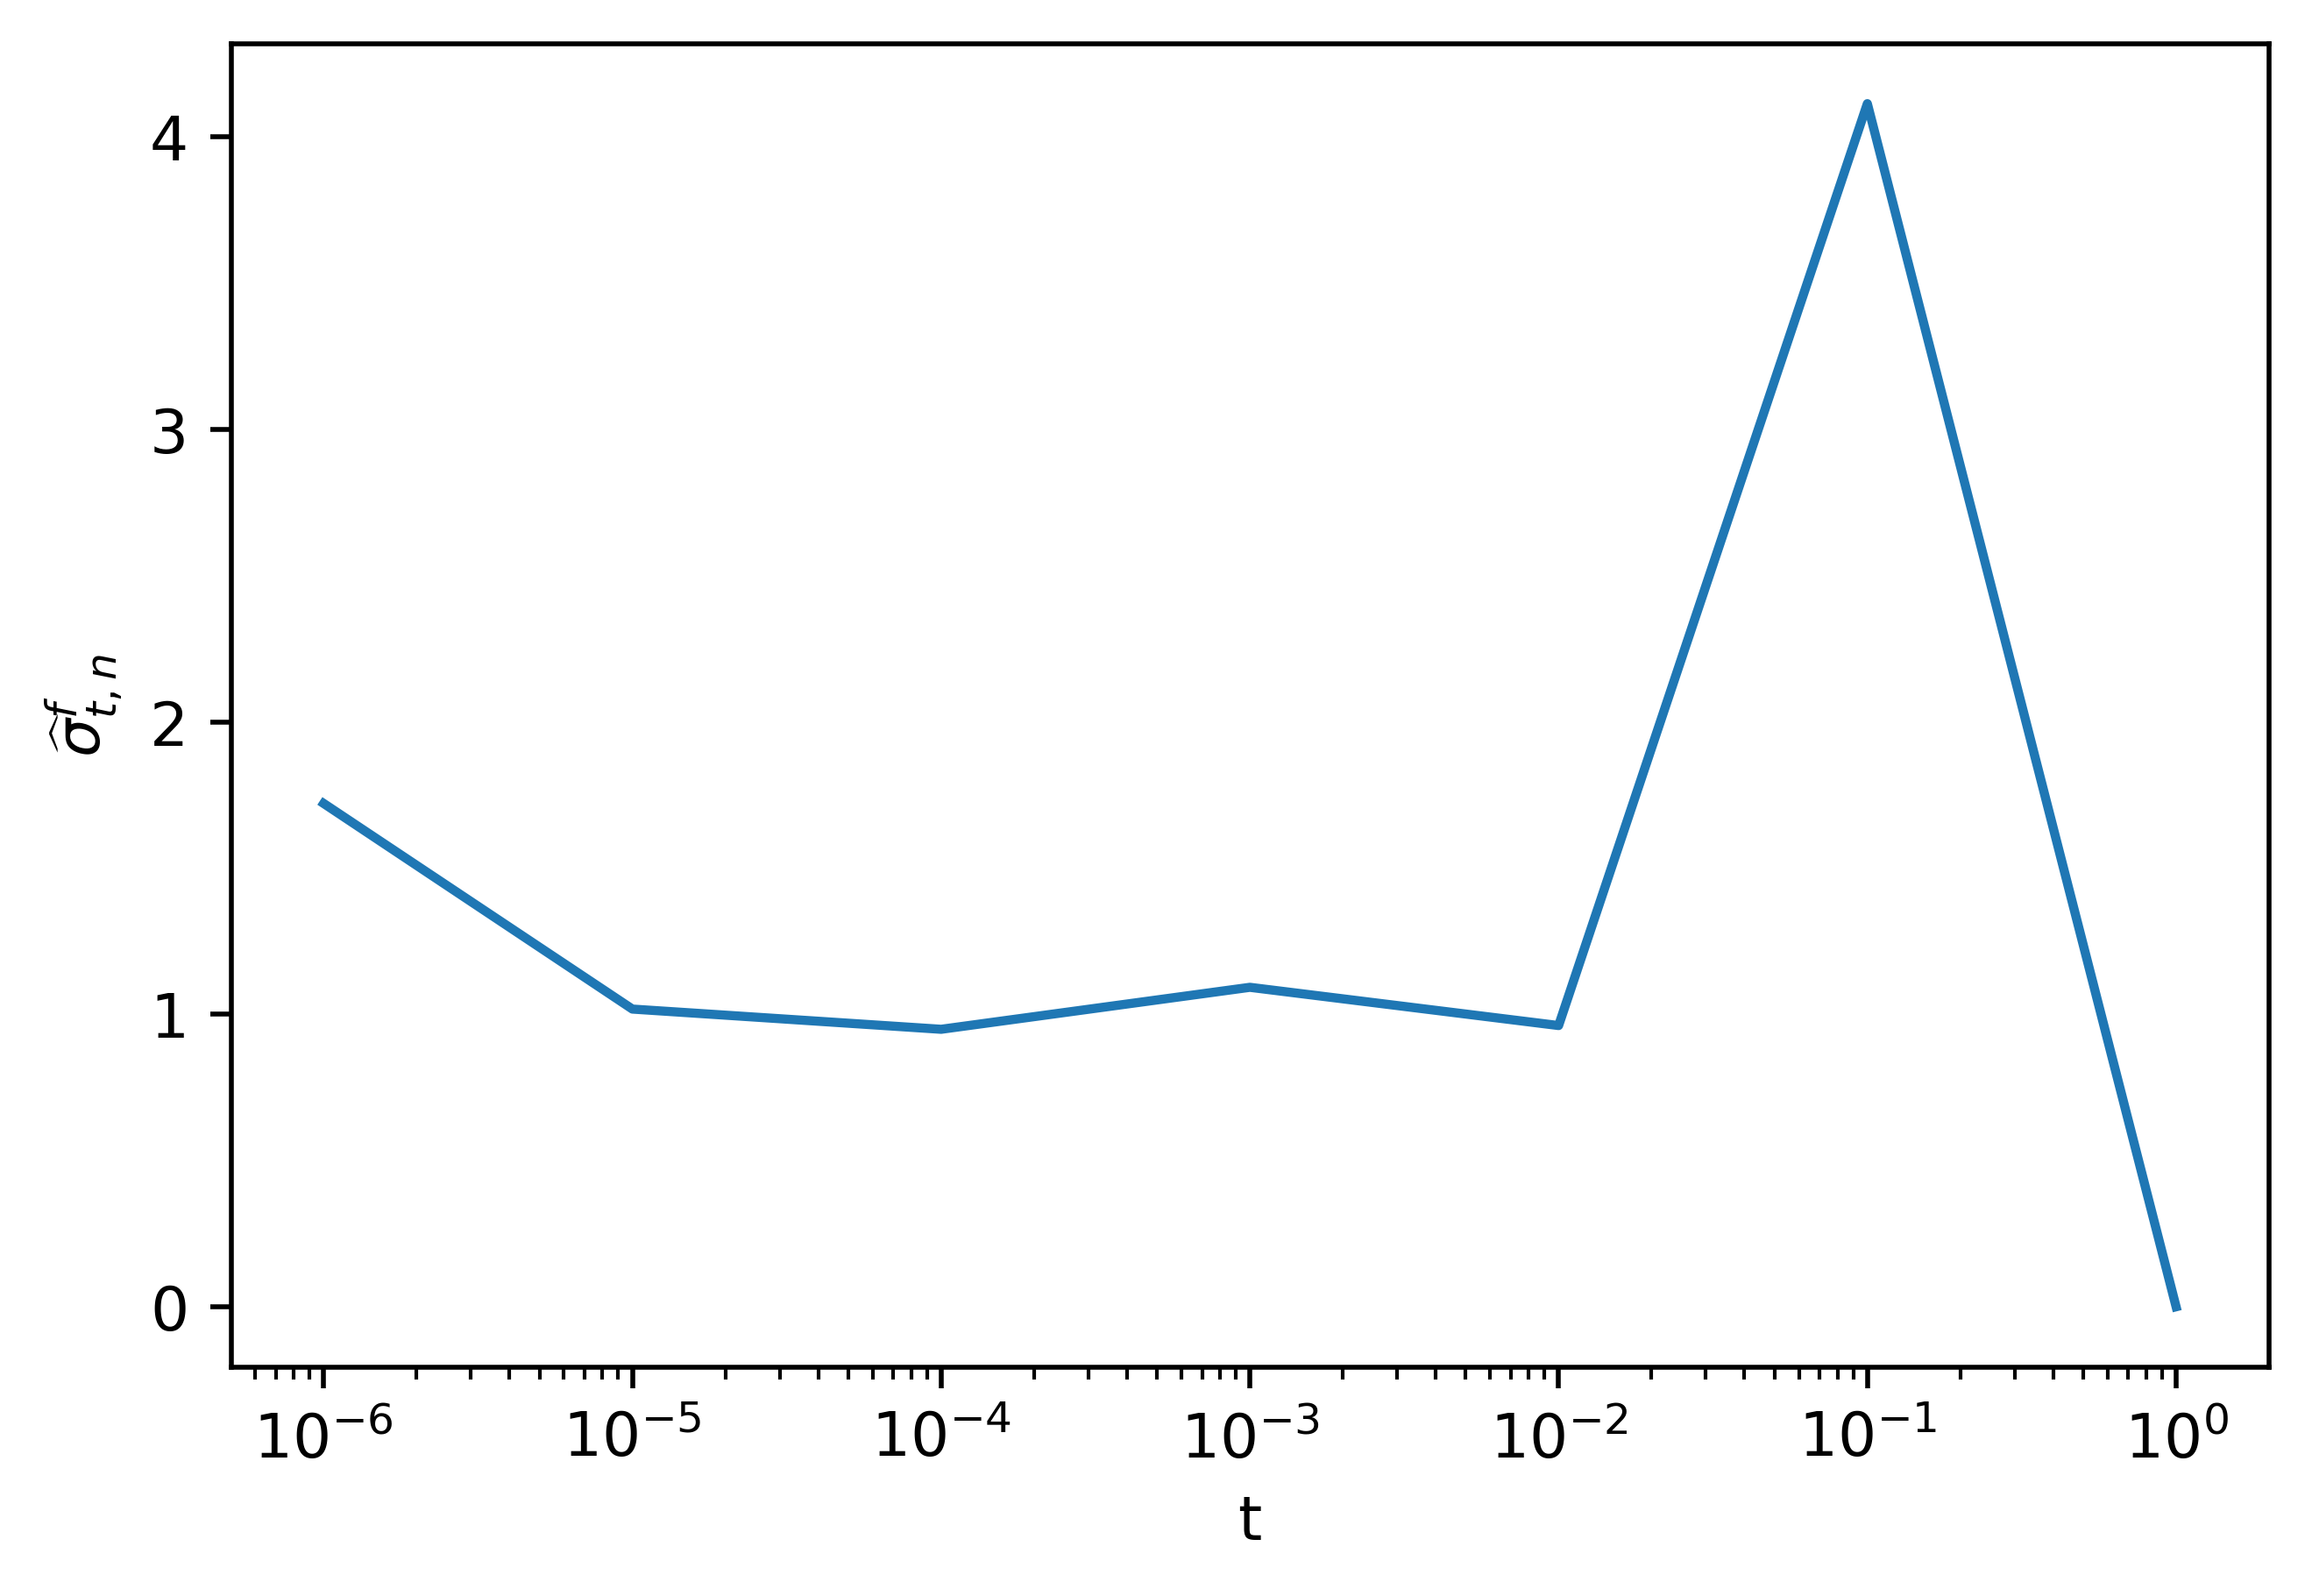

In [41]:
plt.plot(ts, np.mean(np.squeeze(sigma_hats_Ns), axis = 1))
plt.xlabel('t')
plt.ylabel('$\widehat{\sigma}_{t, n}^f$')
    
#plt.legend()
plt.xscale('log')
#plt.ylim(0.5, 1.5)
#plt.yscale('log')

plt.savefig('../figures/levy/volatility_smallN.png', facecolor='w')
plt.show()
plt.close()

### Summary Stats

#### Estimators, choses $a_n$ that seem to be working

#### Estimators

In [104]:
summary_stats = [np.nanmean, np.nanstd, 'mse',0.05, 0.95]
# in indices, add sample size and etc
summaries = []

## access estimation for simulation with a particular number of of iteration
for n_i, n in zip(range(0, len(Ns)), Ns):

    ### access estimations for simulations with a particular number of iteration
    f_hats_n = f_hats_Ns[n_i]
    F_hats_n = F_hats_Ns[n_i]
    sigma_hats_n = sigma_hats_Ns[n_i]
    summary_n = []
    
    # for different ts
    for t_i, t in zip(range(0, len(ts)), ts):
        
        f_hats_t = f_hats_n[t_i]
        F_hats_t = F_hats_n[t_i]
        sigma_hats_t = sigma_hats_n[t_i]
    
        ### calculate stats
        f_stats = tools.estimation_summary(f_hats_t, summary_stats, f[t_i],  rounding = 10)
        F_stats = tools.estimation_summary(F_hats_t, summary_stats, F[t_i], rounding = 10)
        sigma_stats = tools.estimation_summary(sigma_hats_t, summary_stats, F[t_i], rounding = 10)
    
        f_stats = np.insert(f_stats, 0, f[t_i])
        F_stats = np.insert(F_stats, 0, F[t_i])
        sigma_stats = np.insert(sigma_stats, 0, sigma[t_i])

    
        summary_t = pd.DataFrame([f_stats, F_stats, sigma_stats],
                         columns = ['Target','Mean','Std', 'MSE','5.0\%', '95\%'],
                         index = [np.tile(S[0], 3), np.tile(n, 3), np.tile(t, 3), 
                                  ['$\widehat{f}_n(t)$',
                                    '$\widehat{F}_n(t)$',
                                    '$\widehat{\sigma}_{t, n}^f$']])
        
        summary_t.index.set_names(['S','n', 't', 'Statistics'], inplace = True)
        
        summary_n.append(summary_t)

    # store the summary
    summary_n = pd.concat(summary_n)
    summaries.append(summary_n)


In [105]:
pd.concat(summaries)

Target          Mean  \
S    n       t        Statistics                                                
1000 100000  0.000001 $\widehat{f}_n(t)$            1361.171071   1383.578829   
                      $\widehat{F}_n(t)$               0.000183      0.000183   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.010752   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23599.500858   
                      $\widehat{F}_n(t)$               0.017960      0.017952   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.028064   
     200000  0.000001 $\widehat{f}_n(t)$            1361.171071   1094.964168   
                      $\widehat{F}_n(t)$               0.000183      0.000182   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.811108   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23781.847593   
                      $\widehat{F}_n(t)$               0.017960      0.017983   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.034915   
     500000  0.000001 $\widehat{f}_n(t)$            1361.171071   1402.767855   
                      $\widehat{F}_n(t)$               0.000183      0.000182   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.034226   
             0.000003 $\widehat{f}_n(t)$           22963.576099  23511.723966   
                      $\widehat{F}_n(t)$               0.017960      0.017958   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      1.023984   
     1000000 0.000001 $\widehat{f}_n(t)$            1361.171071   1229.405827   
                      $\widehat{F}_n(t)$               0.000183      0.000183   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.906693   
             0.000003 $\widehat{f}_n(t)$           22963.576099  22837.617944   
                      $\widehat{F}_n(t)$               0.017960      0.017958   
                      $\widehat{\sigma}_{t, n}^f$      1.000000      0.994686   

                                                            Std           MSE  \
S    n       t        Statistics                                                
1000 100000  0.000001 $\widehat{f}_n(t)$            4676.338513  5.021077e+02   
                      $\widehat{F}_n(t)$               0.000041  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      3.472233  1.021250e+00   
             0.000003 $\widehat{f}_n(t)$           20596.859511  4.044003e+05   
                      $\widehat{F}_n(t)$               0.000410  1.000000e-10   
                      $\widehat{\sigma}_{t, n}^f$      0.897685  1.020310e+00   
     200000  0.000001 $\widehat{f}_n(t)$            3413.189775  7.086611e+04   
                      $\widehat{F}_n(t)$               0.000030  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      2.546687  6.575993e-01   
             0.000003 $\widehat{f}_n(t)$           16812.295171  6.695682e+05   
                      $\widehat{F}_n(t)$               0.000303  5.000000e-10   
                      $\widehat{\sigma}_{t, n}^f$      0.731050  1.034196e+00   
     500000  0.000001 $\widehat{f}_n(t)$            3309.878778  1.730292e+03   
                      $\widehat{F}_n(t)$               0.000020  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      2.445995  1.069245e+00   
             0.000003 $\widehat{f}_n(t)$           13259.617756  3.004661e+05   
                      $\widehat{F}_n(t)$               0.000184  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      0.577669  1.012083e+00   
     1000000 0.000001 $\widehat{f}_n(t)$            2411.845976  1.736208e+04   
                      $\widehat{F}_n(t)$               0.000014  0.000000e+00   
                      $\widehat{\sigma}_{t, n}^f$      1.785186  8.217615e-01   
             0.000003 $\widehat{f}_n(t)$           11063.269884  1.586546e+04   
      